# Perceptron Lab





This is the scaffold code for the perceptron lab and each lab will have a similar scaffold. There are both code boxes and discussion boxes that you will need to fill in as part of the lab. For example, the first code box you will fill is found below in section one. It a PerceptronClassifier class with function stubs. In addition to filling out the stubs, you are encouraged to add additional functions, parameters, etc. as you see fit.  You do not need to use the scaffolding, but your learners must minimally support the functions and parameters defined in the scaffolding.

**You should have some discussion for all subtasks** and particularly discussion of results, graphs, etc. Good writing, grammar, punctuation, etc. are important and points will be taken off if these things are lacking. Label all axes on graphs. The report for each subtask might go something like:
In this task I divided the randomly shuffled training set into a training set (70%) and a test set (30%). I tried different values of parameter x from n-m and reported training and test set accuracy in the table.  I kept testing until m because… The accuracy on the training set was highest for values between 2-4 while for the test set the accuracy was highest for values 5 and 6. In most casees just reporting results without discussion will not receive full credit. Thus, your discussion should also include sentences like the following: This is because…  Note that the …  I was surprised to observe… I am not sure why …, but my hypothesis is that …

In [1]:
# imports
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import Perceptron
import numpy as np
import matplotlib.pyplot as plt

## 1. Correctly implement and submit your own code for the perceptron learning algorithm. 

### Code requirements
- Shuffle the data each epoch.
- Implement a way to create a random train/test split. Write your own. In the future you can use the scikit-learn version if you want. 
- Use Stochastic/On-line training updates: Iterate and update weights after each training instance (i.e. not batch updates)
- Implement a stopping criteria: when your model has trained for a number of epochs with no improvement in accuracy, stop training. Note that the weights/accuracy do not usually change monotonically.
- Your class can inherit from the relevant scikit-learn learners, but don't call any of the super methods to accomplish the requirements above.
- You may use other packages for ARFF loading, graphing, generating a random number, etc.

In [2]:
def train_test_split(X, y, split=0.8):
    # Zip the data up
    X_y = list(zip(X, y))

    # shuffle the list
    for i in range(len(X_y)-2):
        j = np.random.randint(i, len(X_y)-2)
        X_y[i], X_y[j] = X_y[j], X_y[i]
    for i in range(len(X_y)-1, -1, -1):
        j = np.random.randint(0, len(X_y))
        X_y[i], X_y[j] = X_y[j], X_y[i]
    
    # split by split value
    threshold = int(np.floor(len(X_y) * split))
    train = X_y[:threshold]
    test = X_y[threshold:]

    # unzip into train and test sets
    X_train, y_train = [list(t) for t in zip(*train)]
    X_test, y_test = [list(t) for t in zip(*test)]

    return X_train, X_test, y_train, y_test

In [442]:
class PerceptronClassifier(BaseEstimator,ClassifierMixin):

    def __init__(self, lr=.1, shuffle=True):
        """ 
            Initialize class with chosen hyperparameters.
        Args:
            lr (float): A learning rate / step size.
            shuffle: Whether to shuffle the training data each epoch. DO NOT 
            SHUFFLE for evaluation / debug datasets.
        """
        self.lr = lr
        self.shuffle = shuffle
        self.scores = []
        
    def fit(self, X, y, deterministic=None, initial_weights=None):
        """ 
            Fit the data; run the algorithm and adjust the weights to find a 
            good solution
        Args:
            X (array-like): A 2D numpy array with the training data, excluding
            targets
            y (array-like): A 2D numpy array with the training targets
            initial_weights (array-like): allows the user to provide initial 
            weights
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        self.weights = self.initialize_weights(X) if not initial_weights else initial_weights
        epochs_without_improvement = 0

        # Add bias
        X = np.hstack((X, np.ones((len(X), 1))))

        # Train loop (while epoch is less than deterministic value and deterministic is not None)
        for epoch in range(deterministic):
            # Randomize if shuffle=True
            if self.shuffle:
                X, y = self._shuffle_data(X, y)

            X_y = list(zip(X, y))

            for x, y_truth in X_y:
                # use delta rule to calculate weight changes
                prediction = 1 if np.dot(x, self.weights) > 0 else 0
                delta_weights = np.array([self.lr * (y_truth - prediction) * x_i for x_i, i in zip(x, range(len(x)))])

                # Update the weights
                self.weights = delta_weights + self.weights

            # Run score function on training data and store this (for graphs)
            score = self.score(X, y)
            # print("Score ", score)
            self.scores.append(score)

            # Stopping criteria
            if epoch > 2 and self.scores[epoch] <= self.scores[epoch-1]:
                epochs_without_improvement += 1
            else:
                epochs_without_improvement += 0
            
            if epochs_without_improvement == 25:
                break
            
        return self

    def predict(self, X):
        """ 
            Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding 
            targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        # use the weights to calculate the output, compare with 0 (threshold) then return 1 or 0
        predictions = np.array([1 if np.dot(x,self.weights) > 0 else 0 for x in X])

        return predictions

    def initialize_weights(self, X):
        """ Initialize weights for perceptron. Don't forget the bias!
        Returns:
        """
        # Initialize weights randomly betwen -1 and 1, then return
        print("Initializing Weights")
        return np.random.uniform(-1, 1, len(X[0]) + 1)

    def score(self, X, y):
        """ 
            Return accuracy of model on a given dataset. Must implement own 
            score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """

        # Predict using self.weights on all x
        pred = self.predict(X)
        
        # Compare pred to target, count number of correct
        correct = 0
        for y_hat, y_truth in zip(pred, y):
            if y_hat == y_truth:
                correct += 1

        # Return the average (accuracy)
        return correct / len(y)

    def _shuffle_data(self, X, y):
        """ 
            Shuffle the data! This _ prefix suggests that this method should 
            only be called internally.
            It might be easier to concatenate X & y and shuffle a single 2D 
            array, rather than shuffling X and y exactly the same way, 
            independently.
        """
        X_y = list(zip(X, y))

        # Fisher-Yates shuffle algorithm both forwards and backwards to ensure sufficient shuffledness
        for i in range(len(X_y)-2):
            j = np.random.randint(i, len(X_y)-2)
            X_y[i], X_y[j] = X_y[j], X_y[i]

        for i in range(len(X_y)-1, -1, -1):
            j = np.random.randint(0, len(X_y))
            X_y[i], X_y[j] = X_y[j], X_y[i]

        return [list(t) for t in zip(*X_y)]

    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        return self.weights

## 1.1 Debug and Evaluation

Use your perceptron code first to solve the Debug data. We provide you with several parameters, and you should be able to replicate our results every time. When you are confident your code is correct, run your perceptron on the Evaluation data with the same parameters.

Debug and Evaluate your model using the parameters below

Learning Rate = 0.1 \ 
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it] \ 
Shuffle = False \ 
Initial Weights = All zeros

---

### 1.1.1 (20%) Debug

Debug your model by running it on the [debug dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff)

Expected Results:

Accuracy = [0.88]\
Final Weights = [-0.23  0.18 -0.1 ]

In [443]:
import arff

# Load debug data
# https://github.com/cs472ta/CS472/blob/master/old/TUTORIAL.m
arff_path = "linsep2nonorigin.arff"
debug_data = arff.Arff(arff=arff_path, label_count=1)[:]
X = debug_data[:,:2]
y = debug_data[:,2]

# Train on debug data
model = PerceptronClassifier(lr=.1, shuffle=False)
model.fit(X, y, deterministic=10, initial_weights=[0]*(len(X[0])+1))

# Have your code print your accuracy and weights
print("Accuracy = {:.2f}".format(model.scores[-1]))
print("Final Weights =", model.get_weights())



Accuracy = 0.88
Final Weights = [-0.23  0.18 -0.1 ]


*Discussion*

I used the given `arff.py` file to load the arff data because it seemed the simplest. I sliced the data to get the X values and the y values. After that, I create a model using my PerceptronClassifier class and give it a learning rate of `.1` and turn off the shuffling functionality, like the directons say. Then I run the `fit()` function and give it the data and set the deterministic value (number of epochs) to `10 and then I pass in the initial weights in the form of an expression that creates a list of zeros of the size of the X values plus one for the bias.

The end results were as expected, which means my perceptron is working correctly. The accuracy was `87.5%` (.88 rounded) and the final weights were `[-0.23  0.18 -0.1 ]`

The fit function works as such:

The weights are initialized unless initial weights are provided, then then a bias vector is added to all the data (just a column of the value 1). After this, the training loop begins. Every epoch will start by randomizing the dataset if the shuffle boolean is set to true, then it loops through the data. For each data, it first calculates a prediction and then calculates the change in weights (delta weights) by using `delta_w = learning rate * (truth - prediction) * x_i`. These values are added to the current weights and saved. After doing this for all of the data, it calcuates the score (accuracy) and appends it to the list of scores. Then it either continues to the next epoch or stops if there are `25` epochs with no improvement in accuracy.

The random train/test split function works by randomizing the data and then calculates the number of data points needed for the input threshold (so if there are 80 data points, and the threshold is set to .8, then it'll use 80 * .8 = 64) used to split the randomized data.

### 1.1.2 (20%) Evaluation

We will evaluate your model based on it's performance on the [evaluation dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff). Use the same parameters as the debug dataset

In [444]:
# Load evaluation data
arff_path = "data_banknote_authentication.arff"
eval_data = arff.Arff(arff=arff_path, label_count=1)[:]
X = eval_data[:,:4]
y = eval_data[:,4]

# Train on evaluation data
model = PerceptronClassifier(lr=.1, shuffle=False)
model.fit(X, y, deterministic=10, initial_weights=[0]*(len(X[0])+1))

# Have your code print your accuracy and weights
print("Accuracy = {:.2f}".format(model.scores[-1]))
print("Final Weights =", model.get_weights())

Accuracy = 0.99
Final Weights = [-3.80657242 -2.840821   -3.0719334  -1.4003906   4.9       ]


*Discussion*

As directed, the parameters for the model were the same as the ones used for the debug dataset. This data set did have more features, so the initial weight matrix had 5 zeros instead of 3. Other than that, the model fit the same way as before, but this time with more data! It finished with an accuracy of `99%`. The final weights were larger than the debug dataset's weights. I think that this is because there was a lot more data to train on, thus there was a lot more opportunity to change weights. The final weights were `[-3.80657242 -2.840821   -3.0719334  -1.4003906   4.9       ]`

## 2. Classifying on linearly separable and non-linearly separable data

### 2.1 (5%) Create 2 datasets

- Both with 8 instances using 2 real valued inputs (ranging between -1 and 1) with 4 instances from each class. 
- One data set should be linearly separable and the other not.



In [96]:
# Create 2 datasets

# Linearly separable
dataset_1 = np.array([
    [-.5,.5,1],
    [.5,.5,0],
    [.1,-.25,1],
    [.33,.66,0],
    [.4,.3,0],
    [.79,-.66,0],
    [-.25,-.25,1],
    [-.8,-.3,1]])

# Not linearly separable
dataset_2 = np.array([
    [-.5,.5,1],
    [.5,.5,0],
    [.1,-.25,1],
    [.33,.66,0],
    [.4,.3,1],
    [.79,-.66,0],
    [-.25,-.25,1],
    [-.8,-.3,0]])

*Discussion*

Both datasets have the same x values but they have different y values. The first one is linearly separable essentially on the left half of the points vs the right half of the points. The second dataset is not linearly separable because one class is the middle four points and the other class is the outer 4 points.

### 2.2 (5%) Train on both sets with your perceptron code (with LR=.1)

In [97]:
# Train on each dataset

# Dataset 1
X_1 = dataset_1[:,:2]
y_1 = dataset_1[:,2]

model1 = PerceptronClassifier(lr=.1, shuffle=False)
model1.fit(X_1, y_1, deterministic=10, initial_weights=[0]*(len(X_1[0])+1))
print("Dataset 1")
print("Accuracy = {:.2f}".format(model1.scores[-1]))
print("Final Weights =", model1.get_weights(), "\n")

# Dataset 2
X_2 = dataset_2[:,:2]
y_2 = dataset_2[:,2]

model2 = PerceptronClassifier(lr=.1, shuffle=False)
model2.fit(X_2, y_2, deterministic=10, initial_weights=[0]*(len(X_2[0])+1))
print("Dataset 2")
print("Accuracy = {:.2f}".format(model2.scores[-1]))
print("Final Weights =", model2.get_weights())

Dataset 1
Accuracy = 1.00
Final Weights = [-0.123 -0.091  0.   ] 

Dataset 2
Accuracy = 0.62
Final Weights = [-0.06  0.15 -0.1 ]


*Discussion*

As expected, the model trained on the non-linearly separable dataset could not find a line to separate the data. It yieled an accuracy of `62%`. Meanwhile the model trained on linearly separable data ended up getting `100%`, meaning it was able to find a line that perfectly separated the data.

### 2.3 (5%) Graph the datasets and their corresponding decision line
 
 - Graph each dataset
 - Use your trained perceptrons above to determine each dataset's decision line
 - For all graphs always label the axes!
 
![Linearly Separable Data](https://raw.githubusercontent.com/rmorain/CS472-1/master/images/perceptron/linearly_separable.png)

![Not Linearly Separable](https://raw.githubusercontent.com/rmorain/CS472-1/master/images/perceptron/not_linearly_separable.png)

In [141]:
# Graphing function
def graph_perceptron(title, data, labels, w):
    # Create a grid
    plt.figure(1)
    xlist = np.linspace(-1.0, 1.0, 100) # create 100 evenly spaced points between -1 and 1 for the x axis
    ylist = np.linspace(-1.0, 1.0, 100) # create 100 evenly spaced points between -1 and 1 for the y axis
    X, Y = np.meshgrid(xlist, ylist) # make coordinate matrix for our x and y lines
    Z = X # optional, I wanted to show the true class distinction

    # Create a plot
    fig,ax=plt.subplots(1,1)
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.xlim(-1,1)
    plt.ylim(-1,1)

    # Scatter plot data points 
    scatter = plt.scatter(data[:,0], data[:,1], c = labels, s=200, cmap='seismic')
    legend = ax.legend(*scatter.legend_elements(num=1), title="Class", loc='lower left') # Legend
    ax.add_artist(legend)

    # Plot the leanrned separator
    slope = (-w[0])/w[1]
    intercept = - (w[2]/w[1])
    eq = slope*xlist + intercept
    plt.plot(xlist,  eq, '-k', )
    # plt.legend(['Learned Separator'], bbox_to_anchor=(.42, 1.0), loc = 'upper right') # Legend

    plt.grid() # add grid lines
    plt.show() # show the plot

<Figure size 640x480 with 0 Axes>

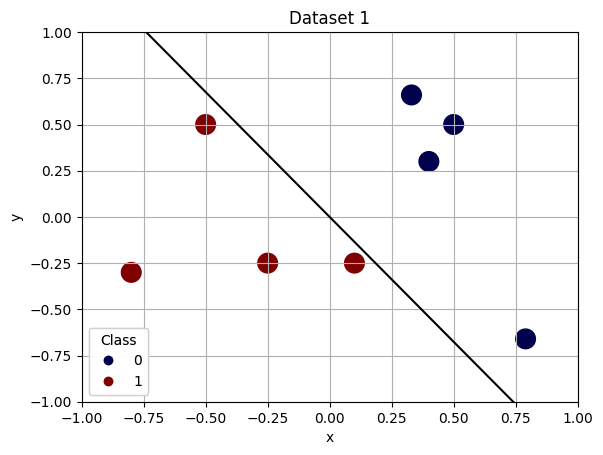

<Figure size 640x480 with 0 Axes>

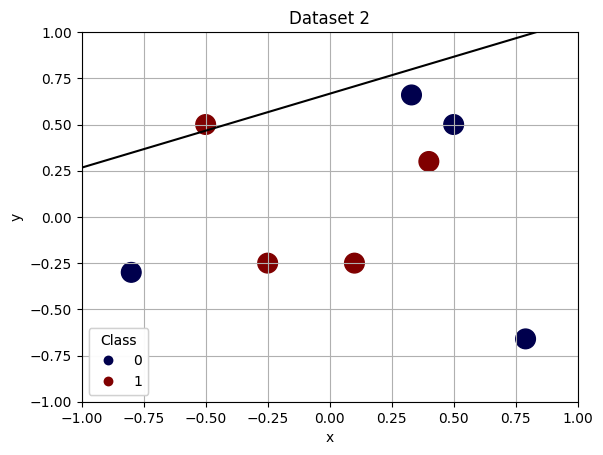

In [142]:
graph_perceptron("Dataset 1", dataset_1[:,:2], dataset_1[:, -1], model1.get_weights())
graph_perceptron("Dataset 2", dataset_2[:,:2], dataset_2[:, -1], model2.get_weights())

*Discussion*

As we can see in the first graph above, dataset 1 is linearly separable and the learned weights are shown represented by a line. The split is near the class 1 points because it didn't need to go any further to get 100% on the dataset. In the second graph, it shows the data that is not linearly separable, as discussed previously. The separating line is now very high up so that it gets 100% of the 0 class correct and 1 of the 1 class correct. This ends up being the 62% as reported, but it also shows how it is impossible to do any better with a linear line.

### 2.4 (5%) Discuss why the perceptron won’t converge on non-linearly separable data.

*Discussion*

It is simply not possible to draw a line between data that is non-linearly separable, and thus while learning, the perceptron will keep finding weights that make lines better and better, until it either finds the minimum error that it can calculate (not at 0) or it oscilates between two of the lowest minumums it can find (still not at 0). With more inputs that are transformed (like x^2, y^2, sin(x), etc.) it can find a non-linear line that might be able to fit the data.

## 3. Use your perceptron code to learn this version of the [voting data set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting-dataset.arff).

This particular task is an edited version of the standard voting set, where we have replaced all the “don’t know” values with the most common value for the particular attribute.  

### 3.1 (10%) Create a table that reports the final training and test set accuracy and the number of epochs for each trial.

- Try it five times with different random 70/30 splits. 
- Use your own code to randomize and make splits. 
- Report the 5 trials and the average across the 5 trials in a table (below is an example of what a smaller table might look like).  

| Trial | Training Accuracy | Test accuracy | Number of epochs |
| --- | --- | --- | --- |
| 1 | .95 | .55 | 4 |
| 2 | .85 | .45 | 6 |
| Average | .9 | .5 | 5 | 

*- As a rough sanity check, typical Perceptron test accuracies for the voting data set are 90%-98%.*


In [438]:
# Obtain the data
arff_path = "voting-dataset.arff"
vote_data = arff.Arff(arff=arff_path, label_count=1)[:]
X = vote_data[:,:16]
y = vote_data[:,16]

# Loop 5 times to train 5 models
num_epochs = [20] * 5
models = []

output_table = [["Trial", "Training Accuracy", "Test Accuracy", "Number of Epochs"]]
for i in range(len(num_epochs)):
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, .7)

    # Train
    model = PerceptronClassifier(lr=.1, shuffle=True)
    model.fit(X_train, y_train, deterministic=num_epochs[i])
    train_acc = model.scores[-1]

    # Test
    X_test = np.hstack((X_test, np.ones((len(X_test), 1))))
    test_acc = model.score(X_test, y_test)

    models.append(model)

    # Add results to table
    output_table.append([i + 1, train_acc, test_acc, num_epochs[i]])

    

Initializing Weights
Initializing Weights
Initializing Weights
Initializing Weights
Initializing Weights


In [439]:
# Create the table any way you like
from tabulate import tabulate

average_row = ["Average",np.mean(np.array(output_table[1:])[:,1]), np.mean(np.array(output_table[1:])[:,2]), np.mean(np.array(output_table[1:])[:,3])]
output_table.append(average_row)
table = tabulate(output_table[1:], output_table[0], tablefmt="fancy_grid")
print(table)

╒═════════╤═════════════════════╤═════════════════╤════════════════════╕
│ Trial   │   Training Accuracy │   Test Accuracy │   Number of Epochs │
╞═════════╪═════════════════════╪═════════════════╪════════════════════╡
│ 1       │            0.97205  │        0.942446 │                 20 │
├─────────┼─────────────────────┼─────────────────┼────────────────────┤
│ 2       │            0.916149 │        0.913669 │                 20 │
├─────────┼─────────────────────┼─────────────────┼────────────────────┤
│ 3       │            0.962733 │        0.956835 │                 20 │
├─────────┼─────────────────────┼─────────────────┼────────────────────┤
│ 4       │            0.962733 │        0.942446 │                 20 │
├─────────┼─────────────────────┼─────────────────┼────────────────────┤
│ 5       │            0.928571 │        0.964029 │                 20 │
├─────────┼─────────────────────┼─────────────────┼────────────────────┤
│ Average │            0.948447 │        0.943885 │

*Discussion*

For this task I used my train/test split function at a threshold of .7 to create a randomized 70/30 train/test split. I then trained the data 5 times, all on 20 epochs (I did this to get a more accurate average and for the graph below). I collected the training set and test set accuracies and created the table shown above. Trial 1 had the best training accuracy with .97 while trial 5 had the best test accuracy at .96. The average training accuracy was .948 and the average test accuracy was .944. These values are very close to each other. Additionally, the varying trial results could also be due to the randomization of the data.

### 3.2 (5%) By looking at the weights, do your best to explain what the model has learned and how the individual input features affect the result. Which specific features are most critical for the voting task, and which are least critical? 


In [440]:
features = [
    "handicapped-infants", "water-project-cost-sharing", "adoption-of-the-budget-resolution",
    "physician-fee-freeze", "el-salvador-aid", "religious-groups-in-schools", "anti-satellite-test-ban",
    "aid-to-nicaraguan-contras", "mx-missile", "immigration", "synfuels-corporation-cutback",
    "education-spending", "superfund-right-to-sue", "crime", "duty-free-exports",
    "export-administration-act-south-africa", "BIAS"]
for i in range(len(model.get_weights())):
    print("{:.4f}\t{}".format(model.get_weights()[i], features[i]))

-0.0112	handicapped-infants
-0.3412	water-project-cost-sharing
-0.8514	adoption-of-the-budget-resolution
1.9740	physician-fee-freeze
0.3571	el-salvador-aid
-0.5475	religious-groups-in-schools
0.7889	anti-satellite-test-ban
0.4545	aid-to-nicaraguan-contras
-0.8451	mx-missile
0.3386	immigration
-1.0710	synfuels-corporation-cutback
-0.1826	education-spending
0.1324	superfund-right-to-sue
0.0747	crime
-0.6880	duty-free-exports
0.4778	export-administration-act-south-africa
-1.4027	BIAS


*Explanation goes here*

Above is each of the weights for the last model that had a 96.4% test accuracy. Each of these weights are either added or subtracted by the feature value in order to get a final value that is either greater than 1, or less than or equal to 0. Immediately, we can see that the `handicapped-infants` feature does not matter very much with a weight of -0.0112, since the model learned to basically ignore that. Additional weaker features are the `crime` feature, `eductation-spending` feature, and the `superfund-right-to-sue` feature, which each had a weight within about .1 or less from 0. Conversely we can see that the `physician-fee-freeze` feature has a larger value than the rest, meaning that is a strong indicator of voting preference. Another more significant feature is `synfuels-corporation-cutback` feature, which has a weight of -1.071. The other features range in importance, but they all contribute to the end result of the perceptron.

### 3.3 (5%) Make a graph of the average misclassification rate vs epochs (0th – final epoch).

- Average the misclassification rate for the training set across your 5 trials (not across 5 epochs): mean(number misclassified  /  number of total data points) vs epoch
- For larger number epochs, only include in the average those runs that trained for at least that length


![Average Misclassification Rate](https://raw.githubusercontent.com/rmorain/CS472-1/master/images/perceptron/avg_misclassification_rate_vs_epochs.png)

[0.07142857142857151, 0.05093167701863344, 0.1018633540372672, 0.047204968944099535, 0.04161490683229796, 0.045341614906832306, 0.03913043478260858, 0.0366459627329192, 0.04161490683229818, 0.04906832298136643, 0.03850931677018643, 0.040372670807453326, 0.037267080745341685, 0.045341614906832306, 0.031677018633540444, 0.03354037267080745, 0.04099378881987581, 0.03975155279503095, 0.03788819875776395, 0.05155279503105581]


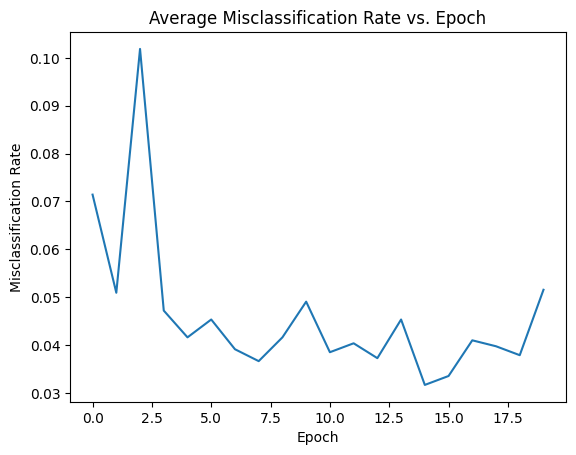

In [441]:
# Graph here
def plot_misclassification(avg_misclassification_rate):
    """
        Plots the average misclassification rate
    Args:
        avg_misclassification_rate (array-like): A 1D array or list
    """
    plt.plot(np.arange(len(avg_misclassification_rate)), avg_misclassification_rate)
    plt.title("Average Misclassification Rate vs. Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Misclassification Rate")
    plt.show()


avg_misclassification_rate = []
for i in range(len(models[-1].scores)):
    total = 0
    for m in models:
        total = total + m.scores[i]
    
    avg_misclassification_rate.append(1 - (total / len(models)))

print(avg_misclassification_rate)
plot_misclassification(avg_misclassification_rate)
    

*Discussion*

I trained all 5 models with 20 epochs and I got this not very smooth graph. This is because there were very few misclassifications, even from epoch 0. The worst it ever got was an average of about 10% misclassified at epoch 2. I found that 20 epochs yieled the smoothest graph (even though it is still not very smooth). Overall with the random intialized weights, the model does pretty well from the beginning, but it still does improve as the number of epochs go up.

## 4.1 (10%) Use the perceptron algorithm from the [scikit-learn toolkit](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) to learn the voting task above.
- Report and compare your results with your own perceptron code.
- Try out some of the hyper-parameters that scikit-learn makes available for the perceptron and discuss your findings. Record your impressions of how scikit-learn works.

In [278]:
# Load sklearn perceptron
scikit_model = Perceptron(verbose=1, max_iter=1000, penalty=None)

# Train on voting dataset
arff_path = "voting-dataset.arff"
vote_data = arff.Arff(arff=arff_path, label_count=1)[:]
X = vote_data[:,:16]
y = vote_data[:,16]

X_train, X_test, y_train, y_test = train_test_split(X, y, .7)

scikit_model.fit(X_train, y_train)
test_acc = scikit_model.score(X_test, y_test)

print(test_acc)


-- Epoch 1
Norm: 13.53, NNZs: 13, Bias: -3.000000, T: 322, Avg. loss: 0.332298
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 17.49, NNZs: 14, Bias: -4.000000, T: 644, Avg. loss: 0.149068
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 18.49, NNZs: 13, Bias: -5.000000, T: 966, Avg. loss: 0.229814
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 20.10, NNZs: 14, Bias: -6.000000, T: 1288, Avg. loss: 0.149068
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 21.10, NNZs: 16, Bias: -7.000000, T: 1610, Avg. loss: 0.214286
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 21.79, NNZs: 15, Bias: -8.000000, T: 1932, Avg. loss: 0.167702
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 22.98, NNZs: 16, Bias: -9.000000, T: 2254, Avg. loss: 0.149068
Total training time: 0.00 seconds.
Convergence after 7 epochs took 0.00 seconds
0.9424460431654677


*Report your comparison and discuss your findings*

The SKlearn perceptron had very similar results to my perceptron. The average test accuracy of my perceptron was .94 while the sklearn perceptron test accuracy was .94. I got individual results both above and below this number. I did notice that it converged after 7 epochs so it did stop earlier than my 20 epochs. I also like that there is a lot more information printed each epoch of training. Overall, it seems like it works very similarly to the perceptron I implemented.

## 4.2 (10%) Use the perceptron algorithm from the [scikit-learn toolkit](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) to learn one other data set of your choice.  
- The UC Irvine Data Repository is a great source, but you may get your data set from wherever you like, though it should represent a real world task.
- Try out some of the hyper-parameters that scikit-learn makes available.

In [397]:
# Load sklearn perceptron
scikit_model = Perceptron(max_iter=100, penalty='l2', early_stopping=True, random_state=100, class_weight="balanced")

# Train on your dataset
arff_path = "caesarian.csv.arff"
caesarian_data = arff.Arff(arff=arff_path, label_count=1)[:]
X = caesarian_data[:,:5]
y = caesarian_data[:,5]

X_train, X_test, y_train, y_test = train_test_split(X, y, .75)



In [402]:
scikit_model.fit(X_train, y_train)
test_acc = scikit_model.score(X_test, y_test)

print("Test accuracy: ", test_acc)

Test accuracy:  0.75


*Discuss your findings and hyperparameters used*

I used the Caesarian Section Classifiation Dataset Data Set https://archive.ics.uci.edu/ml/datasets/Caesarian+Section+Classification+Dataset from UCI. This only had 80 instances but it seemed really interesting to me. The features are age, delivery number, deliver time, blood pressure, and heart problem. This was a mix of nominal features and discrete features. The y output is whether or not the woman got a C-section or not. 

I used Sklearn's Perceptron to learn this task, and it had very varied results. The test accuracy printed above is 75% but when training the model with different train/test splits and different random seeds, you can get a range between 20% and 80% accuracy. There simply isn't enough data for it to converge to a specific number since the variation in the training set and test set can make a big difference.

I tried out several different hyper-parameters. I found the model did a little better with the l2 penalty (for regularization) and the model stopped after less than 10 epochs continually despite the higher max_iter value. I also used the "balanced" class weight for weight initialization. Again, there weren't distinctly better hyperparameters for this dataset due to the small size.

## 5. (Optional 5% extra credit) Use the perceptron rule to learn the [iris task](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff) or some other task with more than two possible output values. 

Note that the [iris data](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff) set has 3 output classes, and a perceptron node only has two possible outputs.  You could implement an approach to deal with this like we discussed in class (review in slides). For testing you just execute the novel instance on each model and report the results. You could break ties using net values but that is not required for this part.

In [427]:
# Code here
arff_path = "iris.arff"
iris_data = arff.Arff(arff=arff_path, label_count=1)[:]

#Iris-setosa
setosa = []
for data in iris_data:
    if data[-1] == 0:
        data[-1] = 1
        setosa.append(data)
    else:
        data[-1] = 0
        setosa.append(data)

X = np.array(setosa)[:,:4]
y = np.array(setosa)[:,4]

# Train on evaluation data
setosa_model = PerceptronClassifier(lr=.1)
setosa_model.fit(X, y, deterministic=5)

# Have your code print your accuracy and weights
print("setosa")
print("Accuracy = {:.2f}".format(setosa_model.scores[-1]))
print("Final Weights =", setosa_model.get_weights())

#Iris-versicolor
versicolor = []
for data in iris_data:
    if data[-1] == 1:
        data[-1] = 1
        versicolor.append(data)
    else:
        data[-1] = 0
        versicolor.append(data)

X = np.array(versicolor)[:,:4]
y = np.array(versicolor)[:,4]

# Train on evaluation data
versicolor_model = PerceptronClassifier(lr=.1)
versicolor_model.fit(X, y, deterministic=5)

# Have your code print your accuracy and weights
print("versicolor")
print("Accuracy = {:.2f}".format(versicolor_model.scores[-1]))
print("Final Weights =", versicolor_model.get_weights())

#Iris-virginica
virginica = []
for data in iris_data:
    if data[-1] == 2:
        data[-1] = 1
        virginica.append(data)
    else:
        data[-1] = 0
        virginica.append(data)

X = np.array(virginica)[:,:4]
y = np.array(virginica)[:,4]

# Train on evaluation data
virginica_model = PerceptronClassifier(lr=.1)
virginica_model.fit(X, y, deterministic=5)

# Have your code print your accuracy and weights
print("virginica")
print("Accuracy = {:.2f}".format(virginica_model.scores[-1]))
print("Final Weights =", virginica_model.get_weights())


Initializing Weights
setosa
Accuracy = 1.00
Final Weights = [ 0.04418162  0.5124473  -0.55342366 -0.87346834  0.94283311]
Initializing Weights
versicolor
Accuracy = 1.00
Final Weights = [-0.13928559  0.88523841 -0.53893716 -1.09315771  0.68369554]
Initializing Weights
virginica
Accuracy = 1.00
Final Weights = [-0.37099681  0.71685364 -0.52291947 -0.0363162  -0.88589155]


*Discussion*

For this classification task, I created a perceptron for each class: setosa, versicolor, and virginica. For each classification, I changed the dataset to become binary. For example, for the setosa perceptron, I changed all the setosa classifications to be 1 and then everything else to be 0. This made it so that each perceptron simply output if the input data is the specific class or not. The three perceptrons together can now classify all 3 classes.